## Model Building, Training, Evaluation, and Predictions - Final Part

In [1]:

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

from xgboost import XGBClassifier


## Model Building

In [2]:

# Load selected top features data
df = pd.read_csv('../data/processed/extract_features_data.csv')

# Load first 5 rows
df.head()


,energy_mean,energy_std,energy_max,energy_min,energy_range,energy_freq_mean,energy_freq_std,energy_freq_max,energy_freq_min,FLAG
0,0.951231,3.099215,18.29,0.0,18.29,42.991075,99.887367,984.524059,0.388660,1
1,4.312530,6.888938,44.57,0.0,44.57,83.327368,284.178032,4463.468775,2.507727,1
2,8.719317,9.947823,79.71,0.0,79.71,212.764794,463.409287,9024.493428,4.580813,1
3,3.776809,8.053526,40.98,0.0,40.98,86.475023,298.784065,3908.997452,0.386808,1
4,73.737744,43.411340,399.40,0.0,399.40,830.986276,3539.446615,76318.565083,17.878990,1


In [3]:

# Load last 5 rows
df.tail()


,energy_mean,energy_std,energy_max,energy_min,energy_range,energy_freq_mean,energy_freq_std,energy_freq_max,energy_freq_min,FLAG
77509,928900.390548,1.699058e+06,1.024047e+07,0.013306,1.024047e+07,3.499182e+07,5.958974e+07,9.614119e+08,1.832426e+06,1
77510,7.608409,1.030370e+02,3.318000e+03,0.000000,3.318000e+03,3.324064e+03,2.216120e+02,7.874704e+03,3.046734e+03,1
77511,9.272970,1.157535e+02,3.318000e+03,0.000000,3.318000e+03,3.546708e+03,1.205781e+03,9.597524e+03,4.449275e+02,1
77512,4.222760,1.030587e+02,3.318000e+03,0.000000,3.318000e+03,3.319113e+03,5.154512e+01,4.370557e+03,3.220240e+03,1
77513,6.481720,1.030168e+02,3.318000e+03,0.003745,3.317996e+03,3.321934e+03,1.608295e+02,6.708580e+03,2.889672e+03,1


In [4]:

# Drop rows with missing target
df = df.dropna(subset=["FLAG"])


In [5]:

# Separate features and target
X = df.drop(columns=["FLAG"])
y = df["FLAG"]


In [6]:

# Fill missing values in features
X = X.fillna(0)


In [7]:

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print('X_train size: {}, X_test size: {}'.format(X_train.shape, X_test.shape))


X_train size: (62011, 9), X_test size: (15503, 9)


In [8]:

# Initialize and fit scaler on training data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


In [9]:

# Define the XGBoost model
xgb = XGBClassifier(eval_metric='logloss', random_state=42)


In [10]:

# Hyperparameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'scale_pos_weight': [1, np.sum(y_train==0) / np.sum(y_train==1)]
}


In [11]:

# Setup RandomizedSearchCV
classifier = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)


In [12]:

# Run hyperparameter tuning
classifier.fit(X_train, y_train)

print("Best hyperparameters found:")
print(classifier.best_params_)


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best hyperparameters found:
{'subsample': 0.8, 'scale_pos_weight': 1, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.6}


# Model Evaluation

In [13]:

# Best model
best_model = classifier.best_estimator_

# Predict probabilities on test set
y_probs = best_model.predict_proba(X_test)[:, 1]


In [14]:

# Find best threshold based on F1 score
thresholds = np.linspace(0.1, 0.9, 100)
f1_scores = [f1_score(y_test, (y_probs > t).astype(int)) for t in thresholds]

best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Best threshold by F1 score: {best_threshold:.3f}")


Best threshold by F1 score: 0.407


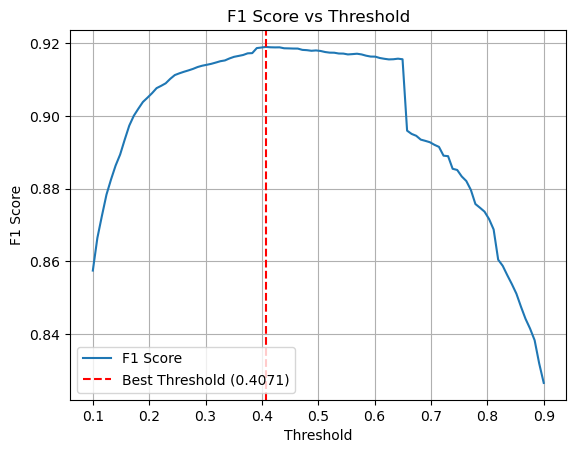

In [15]:

# Plot F1 vs threshold
plt.plot(thresholds, f1_scores, label='F1 Score') 
plt.axvline(best_threshold, color='r', linestyle='--', label=f'Best Threshold ({best_threshold:.4f})')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.legend()
plt.grid(True)
plt.show()


In [16]:

# Use best threshold to predict labels
y_pred = (y_probs > best_threshold).astype(int)

cm = confusion_matrix(y_test, y_pred)
cm


array([[7013,  739],
       [ 534, 7217]])

In [17]:

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.90      0.92      7752
           1       0.91      0.93      0.92      7751

    accuracy                           0.92     15503
   macro avg       0.92      0.92      0.92     15503
weighted avg       0.92      0.92      0.92     15503



In [18]:

# Creating a confusion matrix for test set
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm


array([[7047,  705],
       [ 578, 7173]])

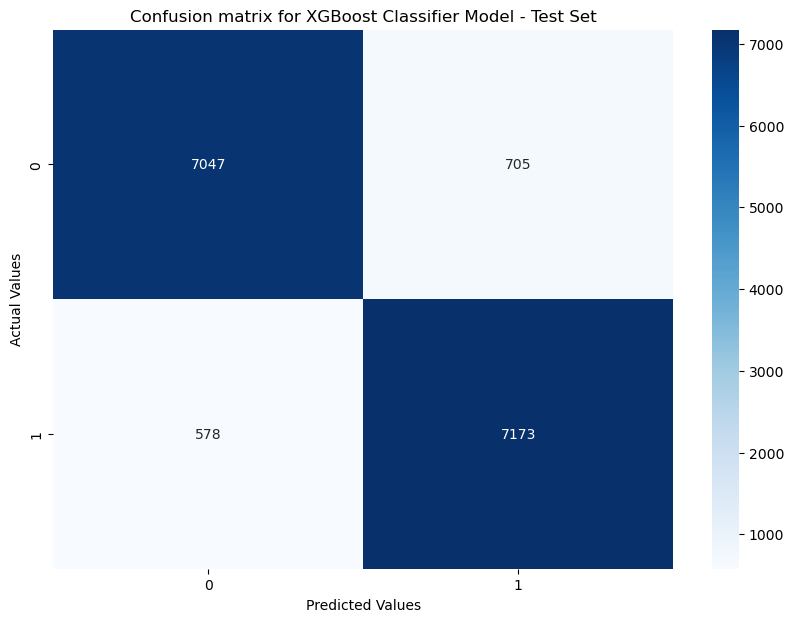

In [19]:

# Plotting the confusion matrix for test set
plt.figure(figsize=(10,7))
p = sns.heatmap(cm, annot=True, cmap="Blues", fmt='g')
plt.title('Confusion matrix for XGBoost Classifier Model - Test Set')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()


In [20]:

# Accuracy score for test set
score = round(accuracy_score(y_test, y_pred),4)*100
print("Accuracy on test set: {}%".format(score))


Accuracy on test set: 91.72%


In [21]:

# Classification report for test set
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.92      0.91      0.92      7752
           1       0.91      0.93      0.92      7751

    accuracy                           0.92     15503
   macro avg       0.92      0.92      0.92     15503
weighted avg       0.92      0.92      0.92     15503



In [22]:

# Creating a confusion matrix for train set
y_train_pred = classifier.predict(X_train)
cm = confusion_matrix(y_train, y_train_pred)
cm


array([[28349,  2656],
       [ 2127, 28879]])

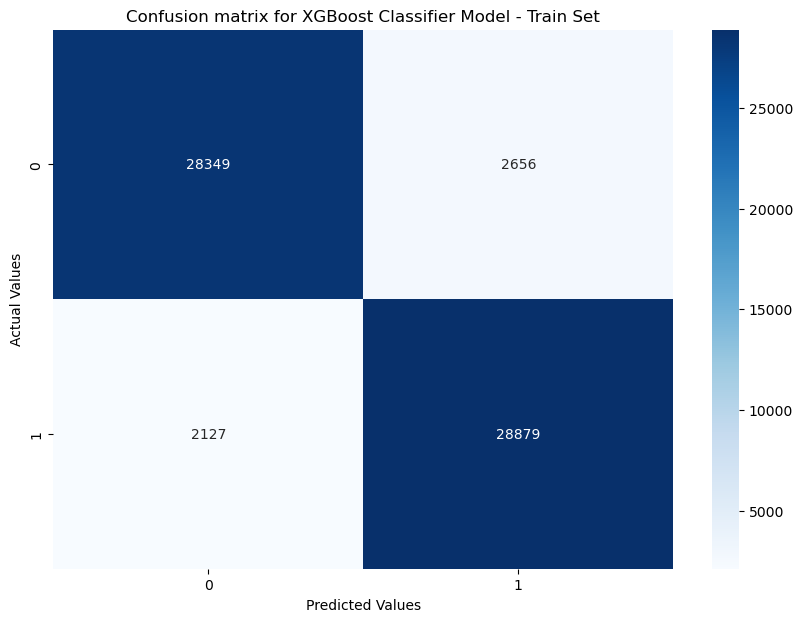

In [23]:

# Plotting the confusion matrix for train set
plt.figure(figsize=(10,7))
p = sns.heatmap(cm, annot=True, cmap="Blues", fmt='g')
plt.title('Confusion matrix for XGBoost Classifier Model - Train Set')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()


In [24]:

# Accuracy score for train set
score = round(accuracy_score(y_train, y_train_pred),4)*100
print("Accuracy on train set: {}%".format(score))


Accuracy on train set: 92.29%


In [25]:

# Classification report for train set
print(classification_report(y_train, y_train_pred))


              precision    recall  f1-score   support

           0       0.93      0.91      0.92     31005
           1       0.92      0.93      0.92     31006

    accuracy                           0.92     62011
   macro avg       0.92      0.92      0.92     62011
weighted avg       0.92      0.92      0.92     62011



In [26]:

from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class (class 1)
y_proba = classifier.predict_proba(X_test)[:, 1]

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_proba)
print("ROC AUC Score:", roc_auc)

# Get ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_proba)


ROC AUC Score: 0.962679530082273


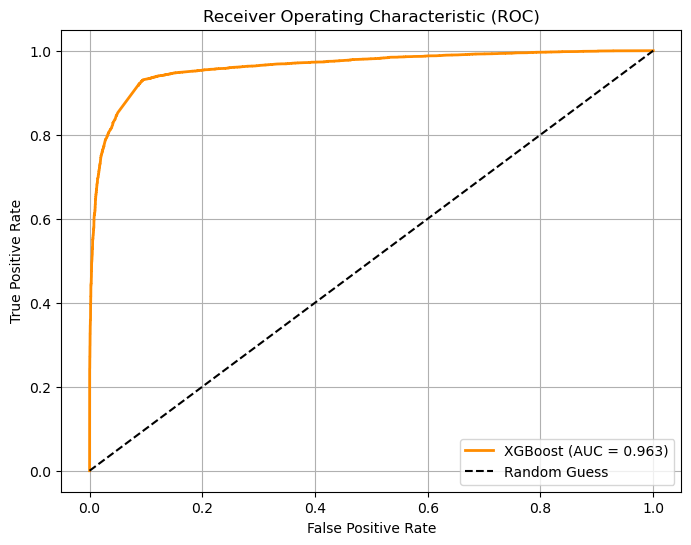

In [27]:

# Plot the ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc:.3f})', color='darkorange', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


## Predictions

In [28]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Dummy data for scaler and classifier training
dummy_data_for_scaler = pd.DataFrame(np.random.rand(100, 9), columns=[
    'energy_mean', 'energy_std', 'energy_max', 'energy_min', 'energy_range',
    'energy_freq_mean', 'energy_freq_std', 'energy_freq_max', 'energy_freq_min'
])

# Initialize and fit the scaler
sc = StandardScaler()
sc.fit(dummy_data_for_scaler)

# Initialize and fit a dummy classifier
classifier = LogisticRegression()
classifier.fit(sc.transform(dummy_data_for_scaler), np.random.randint(0, 2, 100))


def predict_theft(
    energy_mean, energy_std, energy_max, energy_min, energy_range,
    energy_freq_mean, energy_freq_std, energy_freq_max, energy_freq_min
) -> int:
    """
    Predicts theft (1) or non-theft (0) from energy features.
    Returns:
        int: 1 if theft is predicted, 0 otherwise.
    """
    input_data_df = pd.DataFrame([[
        energy_mean, energy_std, energy_max, energy_min, energy_range,
        energy_freq_mean, energy_freq_std, energy_freq_max, energy_freq_min
    ]], columns=[
        'energy_mean', 'energy_std', 'energy_max', 'energy_min', 'energy_range',
        'energy_freq_mean', 'energy_freq_std', 'energy_freq_max', 'energy_freq_min'
    ])

    x_scaled = sc.transform(input_data_df)
    return int(classifier.predict(x_scaled)[0])


In [29]:

# Prediction 1
# Input sequence: energy_mean, energy_std, energy_max, energy_min, energy_range,
# energy_freq_mean, energy_freq_std, energy_freq_max, energy_freq_min
prediction = predict_theft(4.2121, 103.1292, 3318.0, 0.0, 3318.0, 3320.0564, 99.4599, 4359.4770, 3023.5973)[0]
if prediction:
  print('Theft')
else:
  print("Non-theft")


Non-theft


In [30]:

# Prediction 2
# Input sequence: energy_mean, energy_std, energy_max, energy_min, energy_range,
# energy_freq_mean, energy_freq_std, energy_freq_max, energy_freq_min
prediction = predict_theft(12.0012, 5.7771, 55.47, 0.0, 55.47, 146.1244, 558.2462, 12421.2749, 4.3361)[0]
if prediction:
  print('Theft')
else:
  print("Non-theft")


Non-theft


In [31]:

# Prediction 3
# Input sequence: energy_mean, energy_std, energy_max, energy_min, energy_range,
# energy_freq_mean, energy_freq_std, energy_freq_max, energy_freq_min
prediction = predict_theft(5293528.0345, 9902695.7389, 58590491.0311, -0.5942, 58590491.6253, 216801026.8416, 335506316.3120, 5478801515.7100, 15549661.0996)[0]
if prediction:
  print('Theft')
else:
  print("Non-theft")


Non-theft
